In [3]:
pip install torch numpy matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class LTC_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LTC_Cell, self).__init__()
        self.hidden_dim = hidden_dim

        # Learnable parameters
        self.W_xh = nn.Linear(input_dim, hidden_dim)  # Input to hidden
        self.W_hh = nn.Linear(hidden_dim, hidden_dim, bias=False)  # Recurrent weights
        self.W_tau = nn.Linear(hidden_dim, hidden_dim)  # Dynamic time constant

    def forward(self, x, h):
        """
        x: (batch, input_dim) - Input at current timestep
        h: (batch, hidden_dim) - Hidden state from the previous timestep
        """
        # Compute the new time-constant (tau) dynamically
        tau = torch.sigmoid(self.W_tau(h)) + 0.1  # Ensure tau is positive

        # Compute the hidden state update
        dh = -h / tau + torch.tanh(self.W_xh(x) + self.W_hh(h))

        # Euler update: h_next = h + dt * dh
        h_next = h + 0.1 * dh
        return h_next


In [3]:
class LTC_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LTC_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.ltc_cell = LTC_Cell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        """
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_dim)  # Initial hidden state

        for t in range(seq_len):
            h = self.ltc_cell(x[:, t, :], h)  # Update hidden state at each step

        output = self.fc(h)  # Final output
        return output


🔹 Sample Input Sequences (X_train):
[[-0.5204313  -0.60470605 -0.6826899  -0.7535715  -0.8166135  -0.87116003
  -0.9166436  -0.9525911  -0.97862846 -0.9944849  -0.9999954  -0.99510264
  -0.97985756 -0.9544187  -0.91905075 -0.87412167 -0.8200988  -0.7575442
  -0.6871087  -0.60952497 -0.52560014 -0.43620735 -0.3422766  -0.24478501
  -0.14474687 -0.04320287  0.05879057  0.1601724   0.2598879   0.35689974
   0.45019862  0.53881395  0.62182385  0.69836473  0.7676403   0.8289299
   0.88159585  0.9250904   0.95896083  0.982855    0.9965242   0.99982625
   0.99272686  0.9752998   0.9477264   0.9102936   0.8633906   0.8075056
   0.74321985  0.6712022 ]
 [-0.9876876  -0.9666145  -0.9354854  -0.8946242  -0.8444559  -0.78550255
  -0.71837735 -0.6437787  -0.56248254 -0.47533476 -0.38324192 -0.28716213
  -0.18809488 -0.08707083  0.01485904  0.11663433  0.21719624  0.3154986
   0.4105187   0.5012681   0.58680266  0.66623247  0.7387313   0.80354494
   0.859999    0.9075063   0.9455725   0.9738016   0

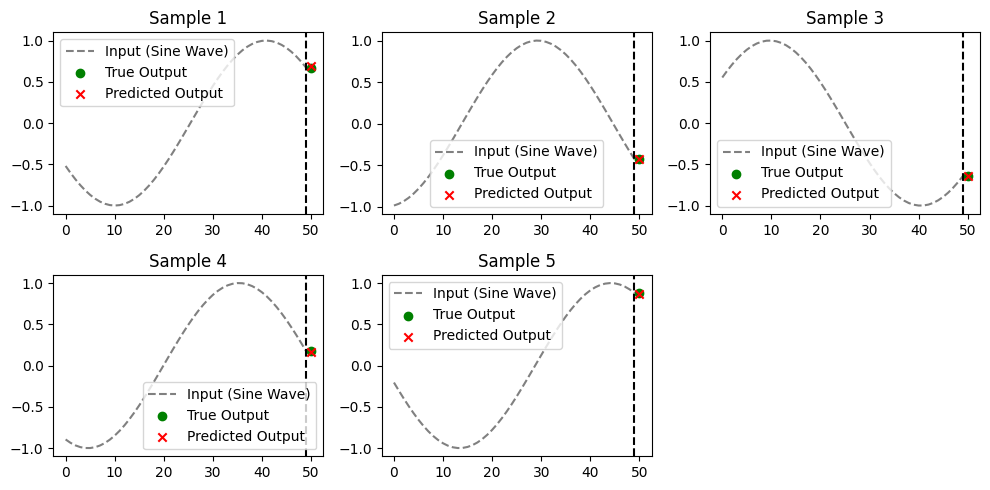

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic sine wave data
def generate_data(seq_len=50, num_samples=5):
    X, Y = [], []
    for _ in range(num_samples):
        start = np.random.uniform(0, 2 * np.pi)
        x = np.sin(np.linspace(start, start + seq_len * 0.1, seq_len))
        y = np.sin(start + seq_len * 0.1)  # Predict next value after sequence
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

# Prepare dataset
X_train, Y_train = generate_data(num_samples=5)  # Use fewer samples for better visualization
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Print input and expected output values
print("\n🔹 Sample Input Sequences (X_train):")
print(X_train.numpy())

print("\n🔹 Expected Outputs (Y_train):")
print(Y_train.numpy())

# Model setup
input_dim = 1
hidden_dim = 16
output_dim = 1
model = LTC_RNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train.unsqueeze(-1))  # Add input dimension
    loss = criterion(output.squeeze(), Y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Convert predictions to numpy for visualization
predictions = output.detach().numpy()

# Print predicted values
print("\n🔹 Model Predictions (After Training):")
print(predictions)

# Plot predictions vs actual values for each sample
plt.figure(figsize=(10, 5))
for i in range(len(Y_train)):
    plt.subplot(2, 3, i + 1)  # Create subplots for better comparison
    plt.plot(X_train[i].numpy(), label="Input (Sine Wave)", linestyle="dashed", color='gray')
    plt.axvline(x=len(X_train[i]) - 1, color='black', linestyle="--")  # Mark last input point
    plt.scatter(len(X_train[i]), Y_train[i].numpy(), color='green', label="True Output", marker="o")
    plt.scatter(len(X_train[i]), predictions[i], color='red', label="Predicted Output", marker="x")
    plt.title(f"Sample {i+1}")
    plt.legend()

plt.tight_layout()
plt.savefig('sin_wave_results.png', dpi=300)
plt.show()

